In [1]:
from brainsmash.mapgen.base import Base
from brainsmash.mapgen.eval import base_fit
from brainsmash.mapgen.stats import pearsonr, pairwise_r, nonparp
import json
import numpy as np
import os
from os.path import join as ospj
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats


In [2]:
def brainSMASH(distMat,map1,map2,bundle_name,labels,nh=25,pv=25):
    gen = Base(map2,distMat,resample=True,nh=nh,pv=pv)
    surrogate_maps = gen(n=1000)
    
    #generate all surrogate correlations
    surrogate_brainmap_corrs = pearsonr(map1, surrogate_maps).flatten()
    surrogate_pairwise_corrs = pairwise_r(surrogate_maps, flatten=True)
    np.savetxt(ospj(brainsmash_dir, "surrogate_brainmap_corrs_%s_map.txt"%(bundle_name)),surrogate_brainmap_corrs,delimiter=",")
    
    
    naive_surrogates = np.array([np.random.permutation(map1) for _ in range(5000)])
    naive_brainmap_corrs = pearsonr(map2, naive_surrogates).flatten()
    naive_pairwise_corrs = pairwise_r(naive_surrogates, flatten=True)
    np.savetxt(ospj(brainsmash_dir, "surrogate_naive_corrs_%s_map.txt"%(bundle_name)),naive_brainmap_corrs,delimiter=",")
    
    # The observed correlation
    test_stat = stats.pearsonr(map1, map2)[0]
    
    #Plotting
    sac = '#99C9C7'  # autocorr-preserving color
    rc = '#E69982'  # randomly shuffled color
    bins = np.linspace(-1, 1, 51)  # correlation b

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_axes([0.2, 0.25, 0.6, 0.6])  # autocorr preserving
    ax2 = ax.twinx()  # randomly shuffled

    # plot the data
    ax.axvline(test_stat, 0, 0.8, color='k', linestyle='dashed', lw=1)
    ax.hist(surrogate_brainmap_corrs, bins=bins, color=sac, alpha=1,
        density=True, clip_on=False, zorder=1)
    ax2.hist(naive_brainmap_corrs, bins=bins, color=rc, alpha=0.7,
        density=True, clip_on=False, zorder=2)

    # make the plot nice...
    ax.set_xticks(np.arange(-1, 1.1, 0.5))
    ax.spines['left'].set_color(sac)
    ax.tick_params(axis='y', colors=sac)
    ax2.spines['right'].set_color(rc)
    ax2.tick_params(axis='y', colors=rc)
    ax.set_ylim(0, 2)
    ax2.set_ylim(0, 6)
    ax.set_xlim(-1, 1)
    [s.set_visible(False) for s in [
        ax.spines['top'], ax.spines['right'], ax2.spines['top'], ax2.spines['left']]]
    ax.text(0.97, .96, 'Permutation', ha='right',va='bottom',
        color=rc, transform=ax.transAxes)
    ax.text(0.97, .9, 'brainSMASH', ha='right', va='bottom',
        color=sac, transform=ax.transAxes)
    ax.text(test_stat, 1.65, "%s\nmap"%labels[0], ha='center', va='bottom') # type of age effect
    ax.text(0.5, -0.2, "Pearson correlation\nfor %s map"%labels[1], # tract
        ha='center', va='top', transform=ax.transAxes)
    ax.text(-0.3, 0.5, "Density", rotation=90, ha='left', va='center', transform=ax.transAxes)
    #plt.title(labels[2])
    plt.show()
    
    

    print("r = ", test_stat)
    print("Spatially naive p-value = ", nonparp(test_stat, naive_brainmap_corrs))
    print("SA-corrected p-value = ", nonparp(test_stat, surrogate_brainmap_corrs))
    print("Critical surrogate brain map corr value = ", np.quantile(surrogate_brainmap_corrs,.95))

In [3]:
config_file="/cbica/projects/luo_wm_dev/code/tract_profiles/config/config_HBN.json"
 
# Read config from the specified file
with open(config_file, "rb") as f:
    config = json.load(f)

dataset = config['dataset']
data_root = config['data_root']
outputs_root = config['outputs_root']
outputs_dir = ospj(outputs_root, "all_subjects")
brainsmash_dir = ospj(outputs_root, "brainsmash_corrs")

if not os.path.exists(brainsmash_dir):
    os.makedirs(brainsmash_dir)
    print(f"{brainsmash_dir} created")

In [4]:
# load files
gam_age_md = pd.read_csv("/cbica/projects/luo_wm_dev/output/HBN/tract_profiles/GAM/dti_md_nocovbat/GAM_bilateral_signedresults.dti_md.age_nocovbat.csv")
bilat_gm_dist = pd.read_csv(ospj(outputs_dir, "across_subjects_bilateral_distances_to_gm.csv"))

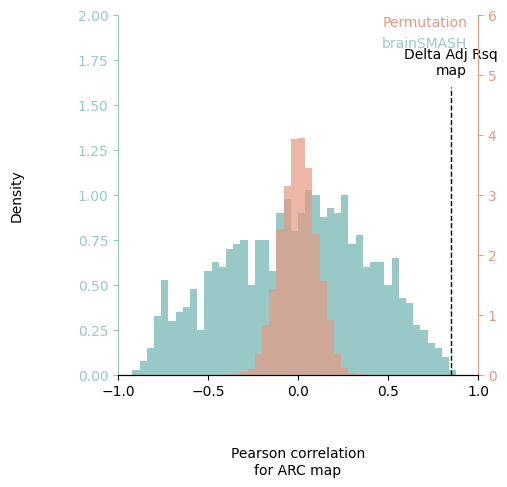

r =  0.8506305011033086
Spatially naive p-value =  0.0
SA-corrected p-value =  0.005
Critical surrogate brain map corr value =  0.6108254746248134


In [5]:

# ARC
bundle_name = "ARC"
distMat = pd.read_csv(ospj(outputs_dir, f"bilat_{bundle_name}_distance_matrix.csv"),header=None)
distMat = distMat.to_numpy().astype(float)

dist_to_gm = bilat_gm_dist[bilat_gm_dist['bundle_name'] == bundle_name].to_numpy()
dist_to_gm_arc = np.delete(dist_to_gm[0], 0)
dist_to_gm_arc = dist_to_gm_arc.astype(float)

age_effect_map = gam_age_md[gam_age_md["tractID"] == "Arcuate Fasciculus"]["s_age.delta.adj.rsq_signed"].to_numpy().astype(float)

brainSMASH(distMat=distMat,map1=dist_to_gm_arc,bundle_name=bundle_name,map2=age_effect_map,labels=["Delta Adj Rsq", bundle_name])

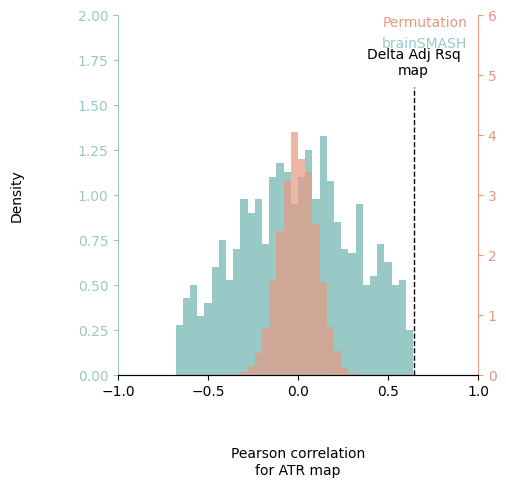

r =  0.6426691590195777
Spatially naive p-value =  0.0
SA-corrected p-value =  0.009
Critical surrogate brain map corr value =  0.5226114100360623


In [6]:
# ATR
bundle_name = "ATR"
distMat = pd.read_csv(ospj(outputs_dir, f"bilat_{bundle_name}_distance_matrix.csv"),header=None)
distMat = distMat.to_numpy().astype(float)

dist_to_gm = bilat_gm_dist[bilat_gm_dist['bundle_name'] == bundle_name].to_numpy()
dist_to_gm_arc = np.delete(dist_to_gm[0], 0)
dist_to_gm_arc = dist_to_gm_arc.astype(float)

age_effect_map = gam_age_md[gam_age_md["tractID"] == "Anterior Thalamic Radiation"]["s_age.delta.adj.rsq_signed"].to_numpy().astype(float)

brainSMASH(distMat=distMat,map1=dist_to_gm_arc,bundle_name=bundle_name,map2=age_effect_map,labels=["Delta Adj Rsq", bundle_name])


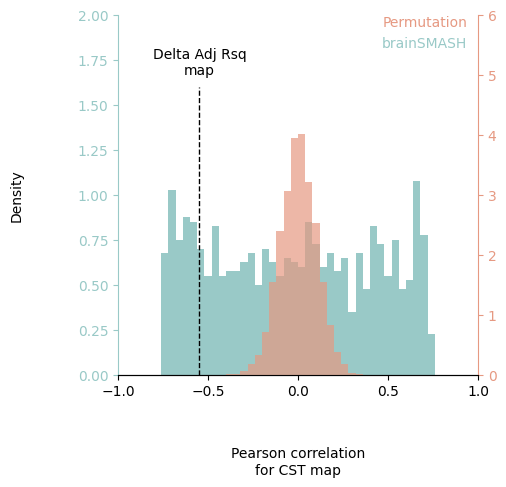

r =  -0.5472695822584146
Spatially naive p-value =  0.0
SA-corrected p-value =  0.301
Critical surrogate brain map corr value =  0.6700628357403096


In [7]:
# CST
bundle_name = "CST"
distMat = pd.read_csv(ospj(outputs_dir, f"bilat_{bundle_name}_distance_matrix.csv"),header=None)
distMat = distMat.to_numpy().astype(float)

dist_to_gm = bilat_gm_dist[bilat_gm_dist['bundle_name'] == bundle_name].to_numpy()
dist_to_gm_arc = np.delete(dist_to_gm[0], 0)
dist_to_gm_arc = dist_to_gm_arc.astype(float)

age_effect_map = gam_age_md[gam_age_md["tractID"] == "Corticospinal Tract"]["s_age.delta.adj.rsq_signed"].to_numpy().astype(float)

brainSMASH(distMat=distMat,map1=dist_to_gm_arc,bundle_name=bundle_name,map2=age_effect_map,labels=["Delta Adj Rsq", bundle_name])


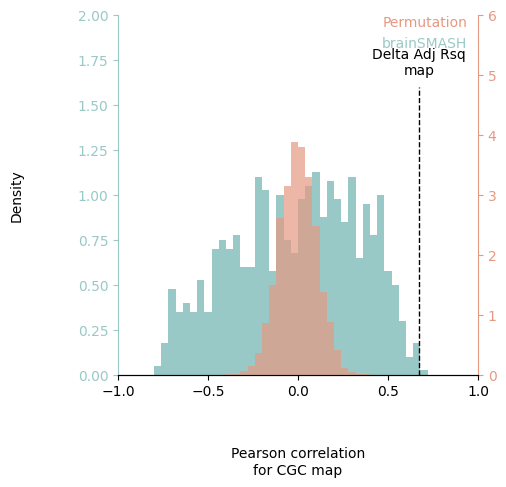

r =  0.6715341141146787
Spatially naive p-value =  0.0
SA-corrected p-value =  0.036
Critical surrogate brain map corr value =  0.5077823448511618


In [8]:
# CGC
bundle_name = "CGC"
distMat = pd.read_csv(ospj(outputs_dir, f"bilat_{bundle_name}_distance_matrix.csv"),header=None)
distMat = distMat.to_numpy().astype(float)

dist_to_gm = bilat_gm_dist[bilat_gm_dist['bundle_name'] == bundle_name].to_numpy()
dist_to_gm_arc = np.delete(dist_to_gm[0], 0)
dist_to_gm_arc = dist_to_gm_arc.astype(float)

age_effect_map = gam_age_md[gam_age_md["tractID"] == "Cingulum Cingulate"]["s_age.delta.adj.rsq_signed"].to_numpy().astype(float)

brainSMASH(distMat=distMat,map1=dist_to_gm_arc,bundle_name=bundle_name,map2=age_effect_map,labels=["Delta Adj Rsq", bundle_name])


In [ ]:
bundles = ["ARCL", "ARCR", "ATRL", "ATRR", "CGCL", "CGCR",  "CSTL", "CSTR", "FA", "FP", "IFOL", "IFOR", "ILFL", "ILFR","pARCL", "pARCR","SLFL", "SLFR","UNCL", "UNCR","VOFL", "VOFR"]


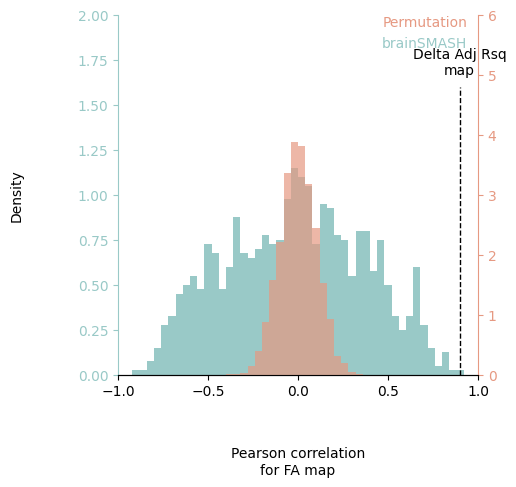

r =  0.8983380008269175
Spatially naive p-value =  0.0
SA-corrected p-value =  0.0
Critical surrogate brain map corr value =  0.6350391633674012


In [9]:
# FA
bundle_name = "FA"
distMat = pd.read_csv(ospj(outputs_dir, f"bilat_{bundle_name}_distance_matrix.csv"),header=None)
distMat = distMat.to_numpy().astype(float)

dist_to_gm = bilat_gm_dist[bilat_gm_dist['bundle_name'] == bundle_name].to_numpy()
dist_to_gm_arc = np.delete(dist_to_gm[0], 0)
dist_to_gm_arc = dist_to_gm_arc.astype(float)

age_effect_map = gam_age_md[gam_age_md["tractID"] == "Forceps Minor"]["s_age.delta.adj.rsq_signed"].to_numpy().astype(float)

brainSMASH(distMat=distMat,map1=dist_to_gm_arc,bundle_name=bundle_name,map2=age_effect_map,labels=["Delta Adj Rsq", bundle_name])


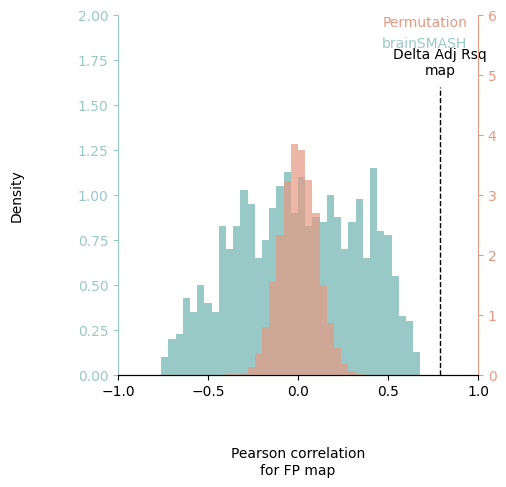

r =  0.7903171975849594
Spatially naive p-value =  0.0
SA-corrected p-value =  0.0
Critical surrogate brain map corr value =  0.5202884471697808


In [10]:
# FP
bundle_name = "FP"
distMat = pd.read_csv(ospj(outputs_dir, f"bilat_{bundle_name}_distance_matrix.csv"),header=None)
distMat = distMat.to_numpy().astype(float)

dist_to_gm = bilat_gm_dist[bilat_gm_dist['bundle_name'] == bundle_name].to_numpy()
dist_to_gm_arc = np.delete(dist_to_gm[0], 0)
dist_to_gm_arc = dist_to_gm_arc.astype(float)

age_effect_map = gam_age_md[gam_age_md["tractID"] == "Forceps Major"]["s_age.delta.adj.rsq_signed"].to_numpy().astype(float)

brainSMASH(distMat=distMat,map1=dist_to_gm_arc,bundle_name=bundle_name,map2=age_effect_map,labels=["Delta Adj Rsq", bundle_name])


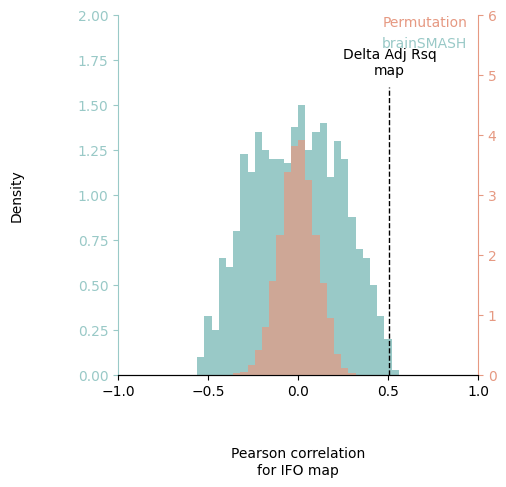

r =  0.5080976834194151
Spatially naive p-value =  0.0
SA-corrected p-value =  0.012
Critical surrogate brain map corr value =  0.38740563505708353


In [11]:
# IFO
bundle_name = "IFO"
distMat = pd.read_csv(ospj(outputs_dir, f"bilat_{bundle_name}_distance_matrix.csv"),header=None)
distMat = distMat.to_numpy().astype(float)

dist_to_gm = bilat_gm_dist[bilat_gm_dist['bundle_name'] == bundle_name].to_numpy()
dist_to_gm_arc = np.delete(dist_to_gm[0], 0)
dist_to_gm_arc = dist_to_gm_arc.astype(float)

age_effect_map = gam_age_md[gam_age_md["tractID"] == "Inferior Fronto-occipital Fasciculus"]["s_age.delta.adj.rsq_signed"].to_numpy().astype(float)

brainSMASH(distMat=distMat,map1=dist_to_gm_arc,bundle_name=bundle_name,map2=age_effect_map,labels=["Delta Adj Rsq", bundle_name])


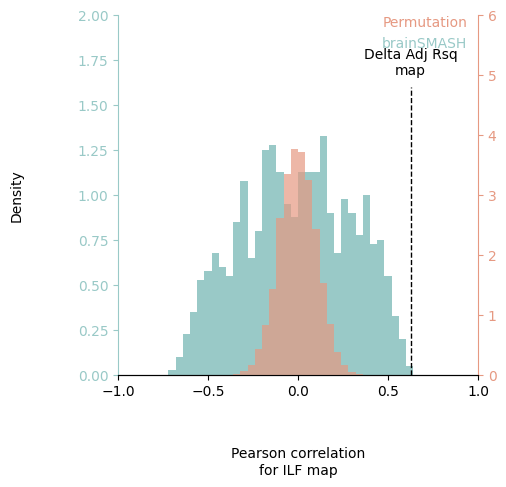

r =  0.6260457224477114
Spatially naive p-value =  0.0
SA-corrected p-value =  0.007
Critical surrogate brain map corr value =  0.47538877646339234


In [12]:
# ILF
bundle_name = "ILF"
distMat = pd.read_csv(ospj(outputs_dir, f"bilat_{bundle_name}_distance_matrix.csv"),header=None)
distMat = distMat.to_numpy().astype(float)

dist_to_gm = bilat_gm_dist[bilat_gm_dist['bundle_name'] == bundle_name].to_numpy()
dist_to_gm_arc = np.delete(dist_to_gm[0], 0)
dist_to_gm_arc = dist_to_gm_arc.astype(float)

age_effect_map = gam_age_md[gam_age_md["tractID"] == "Inferior Longitudinal Fasciculus"]["s_age.delta.adj.rsq_signed"].to_numpy().astype(float)

brainSMASH(distMat=distMat,map1=dist_to_gm_arc,bundle_name=bundle_name,map2=age_effect_map,labels=["Delta Adj Rsq", bundle_name])


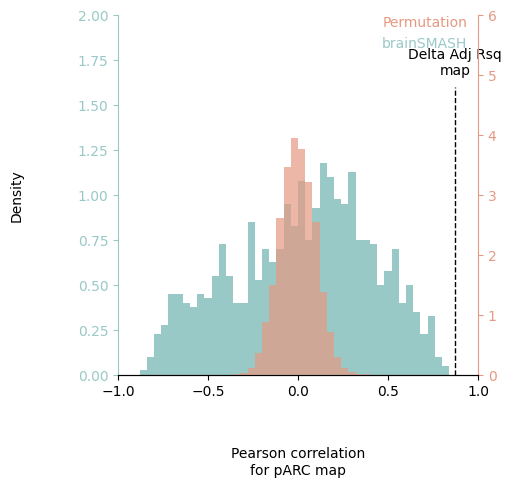

r =  0.8737509178686766
Spatially naive p-value =  0.0
SA-corrected p-value =  0.0
Critical surrogate brain map corr value =  0.6260269674587208


In [13]:
# pARC
bundle_name = "pARC"
distMat = pd.read_csv(ospj(outputs_dir, f"bilat_{bundle_name}_distance_matrix.csv"),header=None)
distMat = distMat.to_numpy().astype(float)

dist_to_gm = bilat_gm_dist[bilat_gm_dist['bundle_name'] == bundle_name].to_numpy()
dist_to_gm_arc = np.delete(dist_to_gm[0], 0)
dist_to_gm_arc = dist_to_gm_arc.astype(float)

age_effect_map = gam_age_md[gam_age_md["tractID"] == "Posterior Arcuate"]["s_age.delta.adj.rsq_signed"].to_numpy().astype(float)

brainSMASH(distMat=distMat,map1=dist_to_gm_arc,bundle_name=bundle_name,map2=age_effect_map,labels=["Delta Adj Rsq", bundle_name])


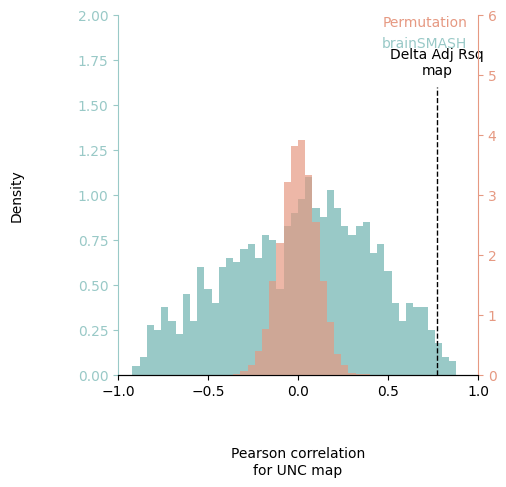

r =  0.773782317237516
Spatially naive p-value =  0.0
SA-corrected p-value =  0.034
Critical surrogate brain map corr value =  0.6493008765468489


In [14]:
# UNC
bundle_name = "UNC"
distMat = pd.read_csv(ospj(outputs_dir, f"bilat_{bundle_name}_distance_matrix.csv"),header=None)
distMat = distMat.to_numpy().astype(float)

dist_to_gm = bilat_gm_dist[bilat_gm_dist['bundle_name'] == bundle_name].to_numpy()
dist_to_gm_arc = np.delete(dist_to_gm[0], 0)
dist_to_gm_arc = dist_to_gm_arc.astype(float)

age_effect_map = gam_age_md[gam_age_md["tractID"] == "Uncinate Fasciculus"]["s_age.delta.adj.rsq_signed"].to_numpy().astype(float)

brainSMASH(distMat=distMat,map1=dist_to_gm_arc,bundle_name=bundle_name,map2=age_effect_map,labels=["Delta Adj Rsq", bundle_name])


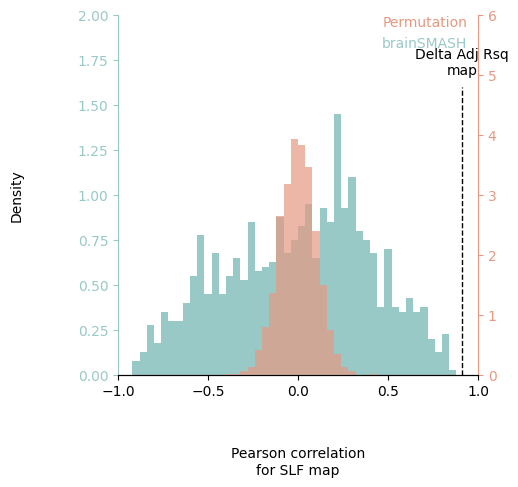

r =  0.9116198980280731
Spatially naive p-value =  0.0
SA-corrected p-value =  0.001
Critical surrogate brain map corr value =  0.6425354960671837


In [15]:
# SLF
bundle_name = "SLF"
distMat = pd.read_csv(ospj(outputs_dir, f"bilat_{bundle_name}_distance_matrix.csv"),header=None)
distMat = distMat.to_numpy().astype(float)

dist_to_gm = bilat_gm_dist[bilat_gm_dist['bundle_name'] == bundle_name].to_numpy()
dist_to_gm_arc = np.delete(dist_to_gm[0], 0)
dist_to_gm_arc = dist_to_gm_arc.astype(float)

age_effect_map = gam_age_md[gam_age_md["tractID"] == "Superior Longitudinal Fasciculus"]["s_age.delta.adj.rsq_signed"].to_numpy().astype(float)

brainSMASH(distMat=distMat,map1=dist_to_gm_arc,bundle_name=bundle_name,map2=age_effect_map,labels=["Delta Adj Rsq", bundle_name])


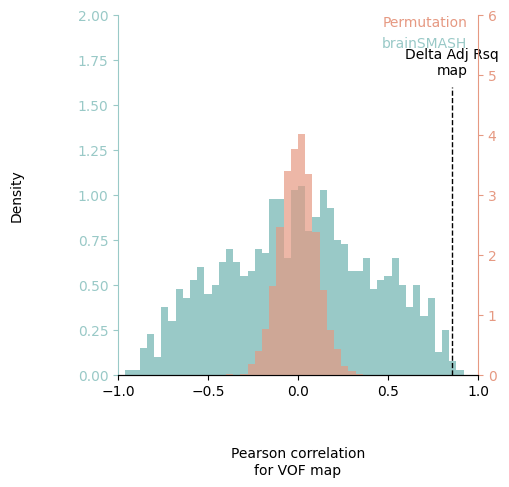

r =  0.8572001793385353
Spatially naive p-value =  0.0
SA-corrected p-value =  0.009
Critical surrogate brain map corr value =  0.6773133355307204


In [16]:
# VOF
bundle_name = "VOF"
distMat = pd.read_csv(ospj(outputs_dir, f"bilat_{bundle_name}_distance_matrix.csv"),header=None)
distMat = distMat.to_numpy().astype(float)

dist_to_gm = bilat_gm_dist[bilat_gm_dist['bundle_name'] == bundle_name].to_numpy()
dist_to_gm_arc = np.delete(dist_to_gm[0], 0)
dist_to_gm_arc = dist_to_gm_arc.astype(float)

age_effect_map = gam_age_md[gam_age_md["tractID"] == "Vertical Occipital Fasciculus"]["s_age.delta.adj.rsq_signed"].to_numpy().astype(float)

brainSMASH(distMat=distMat,map1=dist_to_gm_arc,bundle_name=bundle_name,map2=age_effect_map,labels=["Delta Adj Rsq", bundle_name])


In [23]:
dist = pd.read_csv("/cbica/projects/luo_wm_dev/output/HBN/tract_profiles/all_subjects/across_subjects_bilateral_distances_to_gm.csv")

pd.set_option('display.max_columns', None)
dist


,bundle_name,node_0_dist,node_1_dist,node_2_dist,node_3_dist,node_4_dist,node_5_dist,node_6_dist,node_7_dist,node_8_dist,node_9_dist,node_10_dist,node_11_dist,node_12_dist,node_13_dist,node_14_dist,node_15_dist,node_16_dist,node_17_dist,node_18_dist,node_19_dist,node_20_dist,node_21_dist,node_22_dist,node_23_dist,node_24_dist,node_25_dist,node_26_dist,node_27_dist,node_28_dist,node_29_dist,node_30_dist,node_31_dist,node_32_dist,node_33_dist,node_34_dist,node_35_dist,node_36_dist,node_37_dist,node_38_dist,node_39_dist,node_40_dist,node_41_dist,node_42_dist,node_43_dist,node_44_dist,node_45_dist,node_46_dist,node_47_dist,node_48_dist,node_49_dist,node_50_dist,node_51_dist,node_52_dist,node_53_dist,node_54_dist,node_55_dist,node_56_dist,node_57_dist,node_58_dist,node_59_dist,node_60_dist,node_61_dist,node_62_dist,node_63_dist,node_64_dist,node_65_dist,node_66_dist,node_67_dist,node_68_dist,node_69_dist,node_70_dist,node_71_dist,node_72_dist,node_73_dist,node_74_dist,node_75_dist,node_76_dist,node_77_dist,node_78_dist,node_79_dist,node_80_dist,node_81_dist,node_82_dist,node_83_dist,node_84_dist,node_85_dist,node_86_dist,node_87_dist,node_88_dist,node_89_dist,node_90_dist,node_91_dist,node_92_dist,node_93_dist,node_94_dist,node_95_dist,node_96_dist,node_97_dist,node_98_dist,node_99_dist
0,ARC,0.600940,1.363785,2.141681,2.933518,3.732654,4.535556,5.340182,6.147173,6.953722,7.755662,8.557203,9.353755,10.143833,10.927771,11.705154,12.477293,13.244885,14.006182,14.766058,15.525970,16.290073,17.059661,17.836914,18.623310,19.419508,20.224485,21.040129,21.862036,22.690516,23.523612,24.359084,25.197074,26.035747,26.875920,27.717418,28.561181,29.406862,30.253095,31.102488,31.951877,32.804207,33.659191,34.514036,35.370460,36.223538,37.067718,37.887332,38.638873,39.203217,39.404260,39.142611,38.548894,37.804444,36.992547,36.159409,35.316491,34.472874,33.632663,32.790510,31.949120,31.110302,30.269803,29.427986,28.587269,27.742297,26.899574,26.053737,25.210570,24.368058,23.528250,22.691064,21.858300,21.029850,20.203754,19.385293,18.570219,17.762916,16.961181,16.164761,15.370290,14.581708,13.799813,13.023177,12.253646,11.491297,10.734482,9.985514,9.240296,8.498961,7.762229,7.025837,6.289389,5.553034,4.818672,4.087239,3.363647,2.647844,1.945939,1.252636,0.573203
1,ATR,0.550038,1.230274,1.912172,2.595775,3.278981,3.958389,4.633658,5.304959,5.972054,6.636495,7.300067,7.963497,8.624448,9.288234,9.952164,10.616474,11.282011,11.952210,12.624183,13.298162,13.971534,14.647940,15.326050,16.007478,16.689630,17.377101,18.068935,18.768100,19.475294,20.194846,20.922084,21.662608,22.413387,23.174238,23.945285,24.724394,25.509429,26.300103,27.093512,27.887791,28.684958,29.483119,30.282835,31.083939,31.887814,32.696636,33.508256,34.324671,35.144920,35.969476,36.799064,37.634000,38.472825,39.317010,40.165894,41.016984,41.871472,42.728533,43.586411,44.445812,45.305427,46.163601,47.022069,47.878682,48.733097,49.583274,50.430419,51.272674,52.112200,52.944311,53.769616,54.586034,55.394664,56.194910,56.985697,57.769011,58.545803,59.319749,60.092544,60.866768,61.642900,62.419809,63.202999,63.989666,64.779360,65.573105,66.368527,67.164688,67.963924,68.761613,69.557117,70.349069,71.137185,71.918940,72.696358,73.466802,74.226893,74.977424,75.711697,76.428796
2,CGC,0.563889,1.305303,2.047338,2.788665,3.525764,4.262616,5.009611,5.772132,6.551974,7.353152,8.177965,9.028103,9.901128,10.798048,11.711258,12.647086,13.591382,14.548735,15.513620,16.488025,17.470439,18.456758,19.448982,20.445865,21.449001,22.458173,23.468175,24.483783,25.504608,26.528605,27.552400,28.579044,29.608876,30.639512,31.673127,32.708245,33.742632,34.779150,35.816687,36.855018,37.895367,38.936051,39.970598,41.000338,42.010736,42.956477,43.751677,44.279636,44.428845,44.162621,43.547375,42.713468,41.772810,40.767574,39.742739,38.711693,37.678530,36.644874,35.609929,34.577601,33.543051,32.510480,31.477923,30.444625,29.413077,28.381132,27.354541,26.331052,25.310535,24.293985,23.284035,22.282284,21.290181,20.

In [24]:
dist2 = pd.read_csv("/cbica/projects/luo_wm_dev/output/HCPD/tract_profiles/all_subjects/across_subjects_bilateral_distances_to_gm.csv")

pd.set_option('display.max_columns', None)
dist2

,bundle_name,node_0_dist,node_1_dist,node_2_dist,node_3_dist,node_4_dist,node_5_dist,node_6_dist,node_7_dist,node_8_dist,node_9_dist,node_10_dist,node_11_dist,node_12_dist,node_13_dist,node_14_dist,node_15_dist,node_16_dist,node_17_dist,node_18_dist,node_19_dist,node_20_dist,node_21_dist,node_22_dist,node_23_dist,node_24_dist,node_25_dist,node_26_dist,node_27_dist,node_28_dist,node_29_dist,node_30_dist,node_31_dist,node_32_dist,node_33_dist,node_34_dist,node_35_dist,node_36_dist,node_37_dist,node_38_dist,node_39_dist,node_40_dist,node_41_dist,node_42_dist,node_43_dist,node_44_dist,node_45_dist,node_46_dist,node_47_dist,node_48_dist,node_49_dist,node_50_dist,node_51_dist,node_52_dist,node_53_dist,node_54_dist,node_55_dist,node_56_dist,node_57_dist,node_58_dist,node_59_dist,node_60_dist,node_61_dist,node_62_dist,node_63_dist,node_64_dist,node_65_dist,node_66_dist,node_67_dist,node_68_dist,node_69_dist,node_70_dist,node_71_dist,node_72_dist,node_73_dist,node_74_dist,node_75_dist,node_76_dist,node_77_dist,node_78_dist,node_79_dist,node_80_dist,node_81_dist,node_82_dist,node_83_dist,node_84_dist,node_85_dist,node_86_dist,node_87_dist,node_88_dist,node_89_dist,node_90_dist,node_91_dist,node_92_dist,node_93_dist,node_94_dist,node_95_dist,node_96_dist,node_97_dist,node_98_dist,node_99_dist
0,ARC,0.554162,1.381996,2.223921,3.077478,3.939984,4.804919,5.668548,6.538909,7.405663,8.264996,9.117711,9.966937,10.806729,11.638431,12.461169,13.279320,14.091602,14.903332,15.719208,16.545168,17.380374,18.228991,19.089971,19.957953,20.835969,21.718948,22.608111,23.503256,24.400448,25.301024,26.207678,27.115992,28.024852,28.934774,29.848766,30.763422,31.681876,32.601525,33.525661,34.448626,35.373317,36.299305,37.227295,38.154219,39.080535,40.002028,40.901825,41.754876,42.449027,42.772580,42.561318,41.925120,41.098971,40.211313,39.300621,38.389527,37.477207,36.566701,35.652921,34.738378,33.825104,32.912680,31.996129,31.078097,30.160389,29.240062,28.319358,27.398533,26.478524,25.562249,24.649048,23.740471,22.838049,21.938443,21.044464,20.154455,19.272515,18.397542,17.526141,16.662063,15.803299,14.950104,14.108615,13.273991,12.445726,11.623732,10.814515,10.012448,9.212877,8.415764,7.613365,6.811464,6.004386,5.198829,4.392814,3.595219,2.806348,2.032901,1.271152,0.521049
1,ATR,0.541862,1.220976,1.913039,2.619559,3.342743,4.073764,4.815083,5.562147,6.319378,7.078887,7.848442,8.624114,9.407282,10.195892,10.988209,11.788716,12.591325,13.402907,14.219648,15.039790,15.859929,16.681762,17.502633,18.318412,19.123533,19.919762,20.702478,21.469360,22.232072,22.994993,23.767961,24.556146,25.364993,26.193636,27.044279,27.908123,28.782486,29.663206,30.548158,31.432391,32.312523,33.186409,34.055278,34.920868,35.785395,36.654518,37.527441,38.405907,39.289155,40.174063,41.061863,41.951194,42.844480,43.744926,44.653158,45.568333,46.490077,47.415729,48.345663,49.275518,50.203192,51.128448,52.051768,52.972408,53.890984,54.811153,55.732256,56.653471,57.570808,58.481741,59.383201,60.271717,61.147787,62.010215,62.860522,63.700689,64.533599,65.360379,66.188436,67.021102,67.859683,68.707921,69.564547,70.429542,71.299730,72.173240,73.046917,73.920268,74.795504,75.674042,76.559481,77.449505,78.346711,79.250214,80.158565,81.071879,81.986431,82.895743,83.796497,84.679474
2,CGC,0.501456,1.342276,2.146276,2.910302,3.634246,4.329238,5.008450,5.681216,6.354556,7.046590,7.771524,8.542665,9.368017,10.252772,11.189989,12.173639,13.191855,14.239265,15.302447,16.385390,17.478139,18.583774,19.695400,20.813589,21.938620,23.069747,24.202659,25.342757,26.488515,27.635621,28.784967,29.935694,31.091006,32.246832,33.401240,34.556591,35.711445,36.865803,38.021581,39.175450,40.331813,41.487314,42.642453,43.798111,44.950529,46.072764,47.065638,47.686834,47.714958,47.132751,46.184608,45.111104,43.982726,42.839151,41.695912,40.550970,39.406160,38.262970,37.119002,35.975852,34.832595,33.688577,32.543877,31.398504,30.256551,29.117025,27.978200,26.844050,25.712607,24.588852,23.471168,22.361148,21.260850